In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

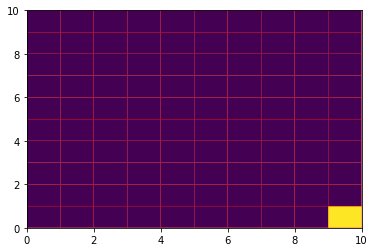

In [166]:
nrow, ncol = 10,10
R1 = [[0 for _ in range(nrow)] for _ in range(ncol)]
R1[9][9] = 1
plt.pcolor(np.flipud(R1), edgecolors='red')

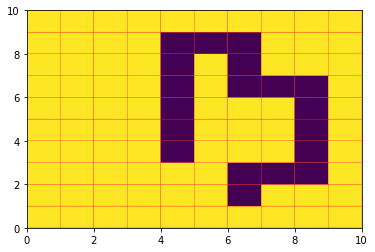

In [16]:
R2 = [[0 for _ in range(nrow)] for _ in range(ncol)]
indices = [(1,4),(1,5),(1,6),(2,4),(2,6),(3,4),(3,6),(3,7),(3,8),(4,4),(4,8),
          (5,4),(5,8),(6,4),(6,8),(7,6),(7,7),(7,8),(8,6)]
for (i,j) in indices:
    R2[i][j] = -100
plt.pcolor(np.flipud(R2), edgecolors='red')

In [260]:
states = [(i,j) for i in range(10) for j in range(10)]
actions = ['up', 'down', 'left', 'right']
arrows = [u'\u2191',u'\u2193',u'\u2190',u'\u2192']
gamma = 0.8
w = 0.1

In [84]:
def edge_state(state):
    (i,j) = state
    if ((i==0 or i==9) and j in range(1,9)) or (i in range(1,9) and (j==0 or j==9)):
        return True
    else:
        return False
    
corner_state = lambda state: state in [(0,0),(0,9),(9,0),(9,9)]

In [295]:
def neighbors(current_state):
    (i,j) = current_state
    if corner_state(current_state):
        if current_state == (0,0):
            return [(i,j),(i,j+1),(i+1,j)]
        elif current_state == (0,9):
            return [(i,j),(i,j-1),(i+1,j)]
        elif current_state == (9,0):
            return [(i,j),(i,j+1),(i-1,j)]
        else:
            return [(i,j),(i,j-1),(i-1,j)]
    elif edge_state(current_state):
        if i==0:
            return [(i,j),(i+1,j),(i,j-1),(i,j+1)]
        elif j==0:
            return [(i-1,j),(i+1,j),(i,j),(i,j+1)]
        elif i==9:
            return [(i-1,j),(i,j),(i,j-1),(i,j+1)]
        elif j==9:
            return [(i-1,j),(i+1,j),(i,j-1),(i,j)]
    else:
        return [(i-1,j),(i+1,j),(i,j-1),(i,j+1)]

In [296]:
def off_grid(state,action):
    (i,j) = state
    if (i==0 and action=='up') or (i==9 and action =='down') or (j==0 and action =='left') or (j==9 and action=='right'):
        return True
    else: 
        return False

In [297]:
def trans_prob(current_state,next_state,action):
    (i,j) = current_state
    neigh = neighbors(current_state)
    directions = ['up','down','left','right']
    if corner_state(current_state):
        if off_grid(current_state,action):
            prob = [1-w+w/4+w/4,w/4, w/4]
        else:
            prob = [w/4+w/4,w/4,w/4] #Initialize all three probs and change one of the probs based on the direction and position
            if (j==0 and action == 'right') or (j==9 and action == 'left'):
                prob[1] = 1-w+w/4
            elif (i==0 and action == 'down') or (i==9 and action == 'up'):
                prob[2] = 1-w+w/4
    else: #This else takes care of both the edges and the middle cases
        prob = [w/4,w/4,w/4,w/4]
        prob[directions.index(action)] = 1-w+w/4
    
    p = prob[neigh.index(next_state)]
    return p

In [298]:
def reward(next_state,reward_func):
    (i,j) = next_state
    if reward_func == 'R1':
        return R1[i][j]
    elif reward_func == 'R2':
        return R2[i][j]
    else:
        print('Invalid reward function specified')

In [324]:
def value_iteration_estimation(reward_function):
    V = [[0 for _ in range(nrow)] for _ in range(ncol)]
    delta = 1e10
    eps = 0.01
    while delta>eps:
        delta = 0
        for current_state in states:
            temp = V[current_state[0]][current_state[1]]
            max_prv = -1e10
            for action in actions:
                prv = 0
                for next_state in neighbors(current_state):
                    P = trans_prob(current_state,next_state,action)
                    R = reward(next_state,reward_function)
                    (i,j) = next_state
                    next_v = V[i][j]
                    prv += P*(R+gamma*next_v)
                if prv>max_prv:
                    max_prv = prv
            V[current_state[0]][current_state[1]] = max_prv
            delta = np.maximum(delta,np.absolute(temp-V[current_state[0]][current_state[1]]))
    
    plt.pcolor(np.flipud(V), edgecolors='red')
    plt.colorbar()
    plt.xticks(np.arange(ncol))
    plt.yticks(np.arange(nrow))    
    plt.show()
    
    fig = plt.figure()
    ax = fig.gca()
    if reward_function == 'R1':
        im = ax.imshow(R1)
    else:
        im = ax.imshow(R2)
    for i in range(nrow):
        for j in range(ncol):
            text = ax.text(j, i, round(V[i][j],2), ha="center", va="center", color="w")
    ax.set_xticks(np.arange(ncol))
    ax.set_yticks(np.arange(nrow))  

In [314]:
def value_iteration_computation(reward_function):
    pi = [[0 for _ in range(nrow)] for _ in range(ncol)]
    for current_state in states:
        prv_vals = []
        for action in actions:
            prv = 0
            for next_state in neighbors(current_state):
                    P = trans_prob(current_state,next_state,action)
                    R = reward(next_state,reward_function)
                    (i,j) = next_state
                    next_v = V[i][j]
                    prv += P*(R+gamma*next_v)
            prv_vals.append(prv)
        pi[current_state[0]][current_state[1]] = np.argmax(prv_vals)

    fig = plt.figure()
    ax = fig.gca()
    if reward_function == 'R1':
        im = ax.imshow(R1)
    else:
        im = ax.imshow(R2)
    for i in range(nrow):
        for j in range(ncol):
            text = ax.text(j, i, arrows[pi[i][j]], ha="center", va="center", color="r")
    ax.set_xticks(np.arange(ncol))
    ax.set_yticks(np.arange(nrow))

## Question 2 and 3

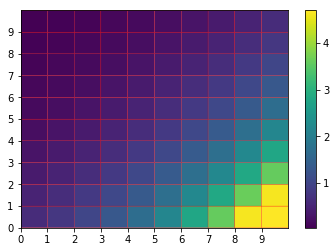

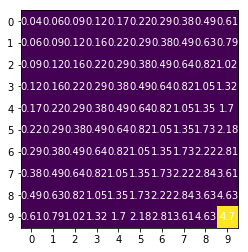

In [325]:
value_iteration_estimation('R1')

## Question 5

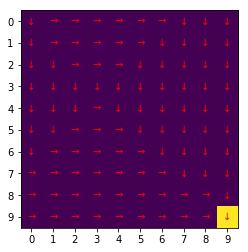

In [302]:
value_iteration_computation('R1')

## Question 6 and 7

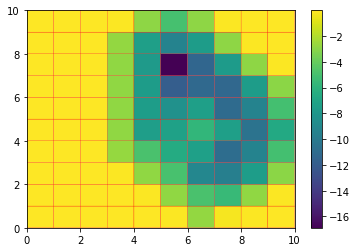

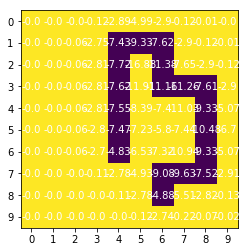

In [308]:
value_iteration_estimation('R2')

## Question 9

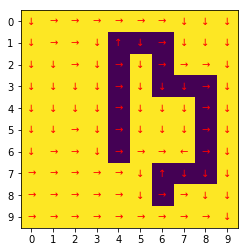

In [304]:
value_iteration_computation('R2')